#### Manual Strategy Execution
I can use the LSEG refinitiv API for data collection | RUN Refinitiv Workspace in background for {Automatic Authentication} <br> I need to do better data analysis and outlier detection etc for better algo development

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
# import refinitiv.data as rd
# from refinitiv.data.content import fundamental_and_reference
import os
from pprint import pprint
import seaborn as sns
from IPython.display import display
import time
from warnings import filterwarnings
import importlib
import pickle

filterwarnings('ignore') 

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [6]:
import utils
import utils.methods
import utils.retrieve
importlib.reload(utils.methods)
importlib.reload(utils.retrieve)

<module 'utils.retrieve' from 'c:\\Users\\Alik\\Desktop\\M_year\\MPhil\\Options\\Quant&Finance\\QRT_Acad\\ML-Pairs-Open\\Research\\utils\\retrieve.py'>

In [7]:
from utils.methods import SelectCointegratedPairs
from utils.retrieve import _call_stocks
from utils.cluster import _agglo_cluster

In [10]:
print(np.__version__)
# print(rd.__version__)

tmp_fields = ["TRDPRC_1", "OPEN_PRC", "HIGH_1", "LOW_1", "ACVOL_UNS"]
benchmark = ['SPY']
start = "2021-01-01"
end = "2024-12-31"
day_limit = 252
variance_perc = 0.9
cluster_distance_threshold = None
cluster_percentile = 20

1.26.4


In [39]:
# api_key = os.environ("LSEG_API_KEY")
# rd.open_session(app_key=api_key)
# rd.open_session()

In [11]:
local_data_dir = '../local_data'

##### Universe Retrieval

In [12]:
stock_universse_path = os.path.join(local_data_dir, 'stock_universe.pkl')

In [ ]:
# stocks = _call_stocks(limit=160, is_nasdaq = True)
# print(stocks[:10])

# print('Stocks: ', len(stocks))

 ---> Number of Sampled Stocks:  53
['POOL.OQ', 'CHRW.OQ', 'FOX.OQ', 'HBAN.OQ', 'ON.OQ', 'EVRG.OQ', 'SMCI.OQ', 'COST.OQ', 'LULU.OQ', 'PAYX.OQ']
Stocks:  53


In [ ]:
# with open(stock_universse_path, 'wb') as f:
#     pickle.dump(stocks, f)
# f.close()

In [13]:
sub_sample = 20

Load-local-stock-universe

In [14]:
with open(stock_universse_path, 'rb') as f:
    stocks = pickle.load(f)
f.close()

stocks = stocks[:sub_sample]
print(stocks[:10])

['POOL.OQ', 'CHRW.OQ', 'FOX.OQ', 'HBAN.OQ', 'ON.OQ', 'EVRG.OQ', 'SMCI.OQ', 'COST.OQ', 'LULU.OQ', 'PAYX.OQ']


We sample a manual universe of 53 NASDAQ(.OQ) stocks for portfolio creation

##### LSEG .get_history() information - A FY has 252 trading days
<br>

| Column Name  | Description  |
|-------------|--------------|
| **TRDPRC_1** | Last traded price (closing price for that period). |
| **HIGH_1** | Highest price reached during the time period. |
| **LOW_1** | Lowest price reached during the time period. |
| **ACVOL_UNS** | Accumulated volume of trades (unscaled). |
| **OPEN_PRC** | Opening price of the asset for that period. |
| **BID** | Last recorded bid price (highest price a buyer is willing to pay). |
| **ASK** | Last recorded ask price (lowest price a seller is willing to accept). |
| **TRNOVR_UNS** | Turnover (traded value) in unscaled units. |
| **VWAP** | **Volume Weighted Average Price** - average trading price considering volume. |
| **BLKCOUNT** | Number of block trades (large transactions executed outside regular markets). |
| **BLKVOLUM** | Volume of shares traded in block trades. |
| **NUM_MOVES** | Number of price movements during the period. |
| **TRD_STATUS** | Trading status (e.g., open, closed, halted, auction, etc.). |
| **SALTIM** | Time of the last trade in seconds from midnight. |
| **CLS_AUCVOL** | Volume traded during the **closing auction**. |
| **OPN_AUCVOL** | Volume traded during the **opening auction**. |
| **VWAP_VOL** | Volume used to calculate VWAP (if different from ACVOL_UNS). |


In [ ]:
# ft = time.time()
# df_uni = rd.get_history(universe=stocks, fields=tmp_fields, interval="1D", start = start, end = end).dropna()
# lt = time.time()

# print('retrieval-time: ', (lt - ft) / 60, 'mins')

# display(df_uni.head(5))

# print(df_uni.shape)

# for nm in stocks:
#     print('NAME:', nm)
#     display(df_uni[nm].head(2))
#     break

retrieval-time:  1.0643401781717936 mins


POOL.OQ                                     CHRW.OQ           \
           TRDPRC_1 OPEN_PRC  HIGH_1   LOW_1 ACVOL_UNS TRDPRC_1 OPEN_PRC   
Date                                                                       
2021-01-04   356.89   373.82   376.6  353.61    121170    92.37    93.65   
2021-01-05   356.87   356.53  359.85  354.38     93096     91.5    91.93   
2021-01-06   370.38    352.2  370.91  350.02    162723    95.24    92.15   
2021-01-07   385.95   374.58  401.29   371.8    177630    96.16    95.49   
2021-01-08   390.99   388.81  398.91  388.09    101915    97.36    96.27   

                                     ...   NVDA.OQ                      \
            HIGH_1  LOW_1 ACVOL_UNS  ...  TRDPRC_1  OPEN_PRC    HIGH_1   
Date                                 ...                                 
2021-01-04   93.97   91.8    451420  ...   13.1135    13.091     13.65   
2021-01-05   92.05  90.64    602003  ...  13.40475  13.09975    13.442   
2021-01-06    95.4  92.15    681763  ...   12.6145  13.24425    13.245   
2021-01-07  96.325  94.57    482556  ...    13.344    12.975   13.3775   
2021-01-08   98.63  96.27    530800  ...  13.27675    13.358  13.41925   

                                 ROST.OQ                                     
               LOW_1  ACVOL_UNS TRDPRC_1 OPEN_PRC  HIGH_1   LOW_1 ACVOL_UNS  
Date                                                                         
2021-01-04   12.9625  142014120   117.07   122.55  123.09   116.5    994322  
2021-01-05   13.0875   94648840   117.17   117.04  117.93  116.01    615746  
2021-01-06  12.58825  168737160   122.29    115.9  123.14   115.9    765921  
2021-01-07   12.8875  131570760   122.02    121.4  123.03  121.29    562431  
2021-01-08  13.04375   85762920   122.41   121.96   123.8  121.23    760697  

[5 rows x 265 columns]

(1005, 265)
NAME: POOL.OQ


,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
Date,,,,,
2021-01-04,356.89,373.82,376.6,353.61,121170
2021-01-05,356.87,356.53,359.85,354.38,93096


Local-Save

In [15]:
local_data_save_path = os.path.join(local_data_dir, 'data_df_53_4Y_1D.pkl') 

In [ ]:
# df_uni.to_pickle(local_data_save_path)

Local-Load

In [16]:
df_uni = pd.read_pickle(local_data_save_path)
df_uni = df_uni[stocks]
df_uni.head(3)

POOL.OQ                           ...  EXPE.OQ                          
           TRDPRC_1 OPEN_PRC  HIGH_1   LOW_1  ... OPEN_PRC  HIGH_1   LOW_1 ACVOL_UNS
Date                                          ...                                   
2021-01-04   356.89   373.82   376.6  353.61  ...   134.76  135.79  128.47    866954
2021-01-05   356.87   356.53  359.85  354.38  ...   131.47  137.91  131.47    982343
2021-01-06   370.38    352.2  370.91  350.02  ...   138.44  147.54   137.0   1181634

[3 rows x 100 columns]

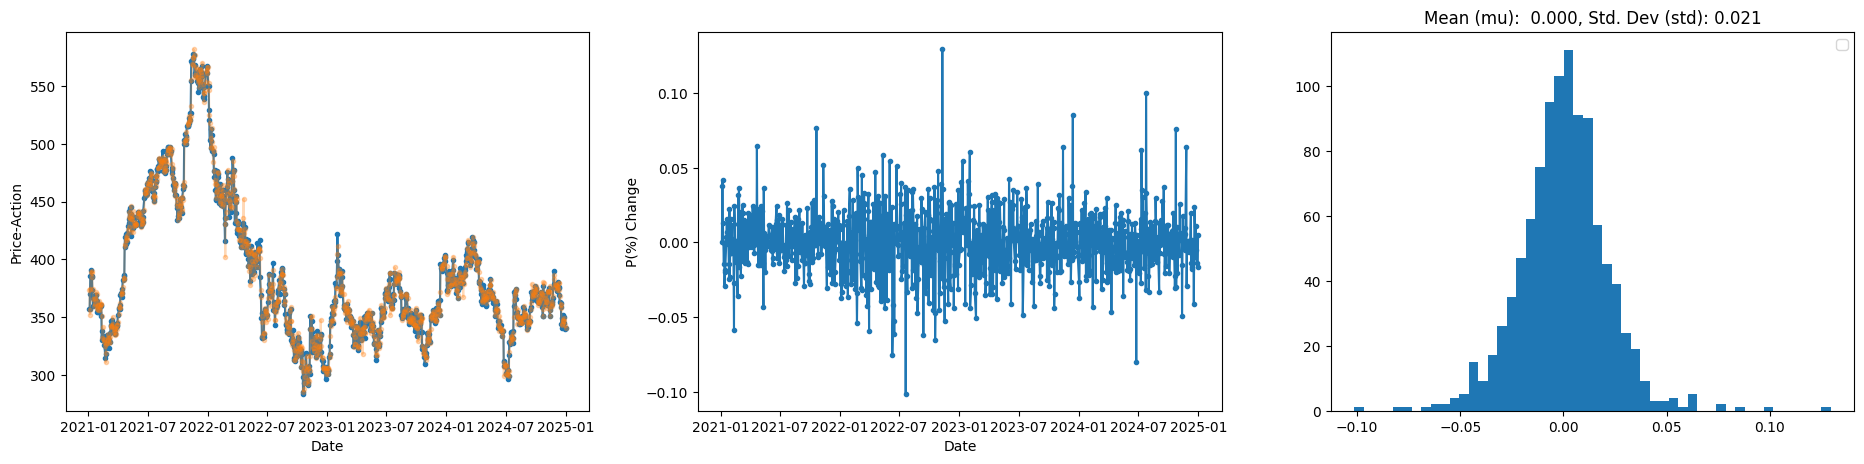

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(19, 5))

### We just do multi-indexing
axs[0].plot(df_uni.index, df_uni[stocks[0]]['TRDPRC_1'], marker = '.', label='close')
axs[0].plot(df_uni.index, df_uni[stocks[0]]['OPEN_PRC'], marker = '.', label='open', alpha=0.3)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price-Action')

axs[1].plot(df_uni.index, df_uni[stocks[0]]['TRDPRC_1'].pct_change(), marker = '.', label='close')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('P(%) Change')

axs[2].hist(df_uni[stocks[0]]['TRDPRC_1'].pct_change(), bins = 50)
_mu = df_uni[stocks[0]]['TRDPRC_1'].pct_change().mean()
_std = df_uni[stocks[0]]['TRDPRC_1'].pct_change().std()
axs[2].set_title(f'Mean (mu):  {_mu:.3f}, Std. Dev (std): {_std:.3f}')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

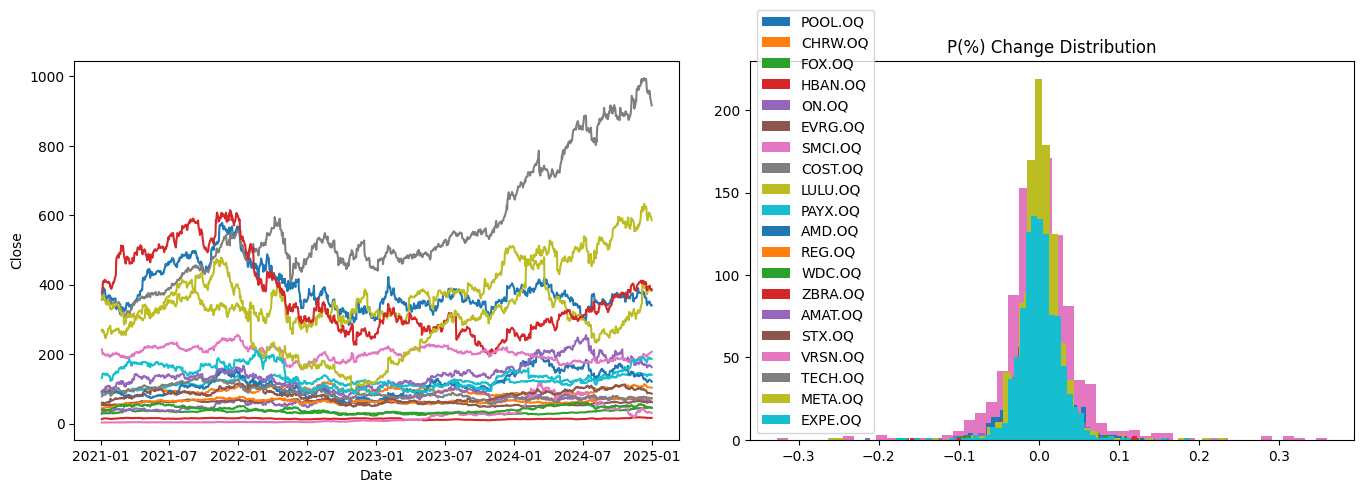

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

### We just do multi-indexing
for nm in stocks:
    axs[0].plot(df_uni.index, df_uni[nm]['TRDPRC_1'], label = nm)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Close')

plt.legend()

for nm in stocks:

    pct_change_clean = df_uni[nm]['TRDPRC_1'].pct_change().dropna()

    if pct_change_clean.empty:
        print(f"Skipping {nm} due to no valid percentage change data.")
        continue
    
    axs[1].hist(pct_change_clean, bins = 50, label = nm)
    axs[1].set_title(f'P(%) Change Distribution')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

In [20]:
# fundamental_df = rd.get_data(
#     universe=stocks,
#     fields=["TR.Revenue.date", "TR.Revenue", "TR.GrossProfit"],
#     parameters={
#         "SDate": start,
#         "EDate": end, # Full fiscal year
#         "FRQ": "D", # Fiscal Year frequency (more standard than "A")
#         "Curn": "USD" # Currency normalization
#     }
# )

# display(fundamental_df.head(5))
# print(fundamental_df.shape)
# print(fundamental_df.columns)

# ## creates multi-index based on column indexing
# fundamental_df = fundamental_df.set_index(['Instrument', 'Date'])

# display(fundamental_df.head(5))
# print(fundamental_df.shape)

# display(fundamental_df.loc[stocks[0]].head(5))
# print(fundamental_df.loc[stocks[0]].shape)

fundamental-local-save

In [21]:
fundamental_save_path = os.path.join(local_data_dir, 'fundamental_df_4Y_1D.pkl')

In [ ]:
# fundamental_df.to_pickle(fundamental_save_path)

fundamental-local-load

In [22]:
fundamental_df = pd.read_pickle(fundamental_save_path).loc[stocks]
fundamental_df.head(3)

Revenue  Gross Profit
Instrument Date                                
POOL.OQ    2019-12-31  3199517000     924925000
           2019-12-31  3199517000     924925000
           2019-12-31  3199517000     924925000

['2019-12-31T00:00:00.000000000' '2020-12-31T00:00:00.000000000'
 '2021-12-31T00:00:00.000000000' '2022-12-31T00:00:00.000000000'
 '2023-12-31T00:00:00.000000000']


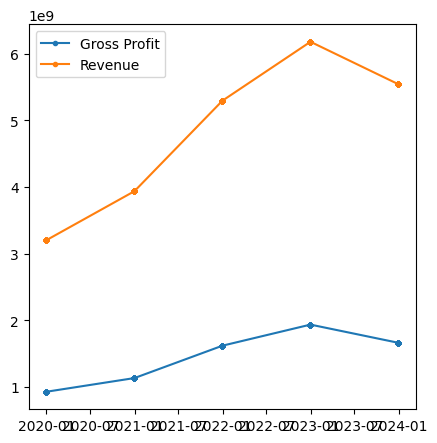

In [23]:
fig = plt.figure(figsize=(5, 5))

print(np.unique(np.array(fundamental_df.loc[stocks[0]].index))) ### Maybe thats the time when gross-profit and revenue gets published (but shouldn't that be q1-4) - annual report for 1FY not quartly 
plt.plot(fundamental_df.loc[stocks[0]].index, fundamental_df.loc[stocks[0]]['Gross Profit'], marker = '.', label = 'Gross Profit')
plt.plot(fundamental_df.loc[stocks[0]].index, fundamental_df.loc[stocks[0]]['Revenue'], marker = '.', label = 'Revenue')

plt.legend()
plt.show()

In [24]:
val_arr = []
_elem_stocks = []

for i, nm in enumerate(stocks):
    pct = np.array(df_uni[nm]['TRDPRC_1'].pct_change().fillna(0)).tolist()
    close = np.array(df_uni[nm]['TRDPRC_1']).tolist()
    vol = np.array(df_uni[nm]['ACVOL_UNS']).tolist()
    revenue = np.array(fundamental_df.loc[nm]['Revenue']).tolist() 
    gross_profit = np.array(fundamental_df.loc[nm]['Gross Profit']).tolist()

    # was = np.array(fundamental_df.loc[nm]['Basic Weighted Average Shares'])

    if (len(revenue) == 1) or (len(gross_profit) == 1):
        _elem_stocks.append(nm)
        continue

    val_arr.append([close, pct, vol, revenue, gross_profit])
    
print(len(val_arr), len(val_arr[0]))
val_arr = np.array(val_arr)
print(val_arr.shape)

stocks = [_s for _s in stocks if _s not in _elem_stocks]
print('New-Stocks: ', stocks)
print(len(stocks))

val_arr = val_arr.reshape(len(stocks), -1)
print(val_arr.shape)


18 5
(18, 5, 1005)
New-Stocks:  ['POOL.OQ', 'CHRW.OQ', 'FOX.OQ', 'ON.OQ', 'SMCI.OQ', 'COST.OQ', 'LULU.OQ', 'PAYX.OQ', 'AMD.OQ', 'REG.OQ', 'WDC.OQ', 'ZBRA.OQ', 'AMAT.OQ', 'STX.OQ', 'VRSN.OQ', 'TECH.OQ', 'META.OQ', 'EXPE.OQ']
18
(18, 5025)


##### PCA + Clustering
A fixed n_components shows systemic risk/volatility which shows fewer components moving the market while unsystemic risk shows diversification and more singular stock trading oppurtunity  

Component-Compress:  (18, 7)


<Figure size 500x500 with 0 Axes>

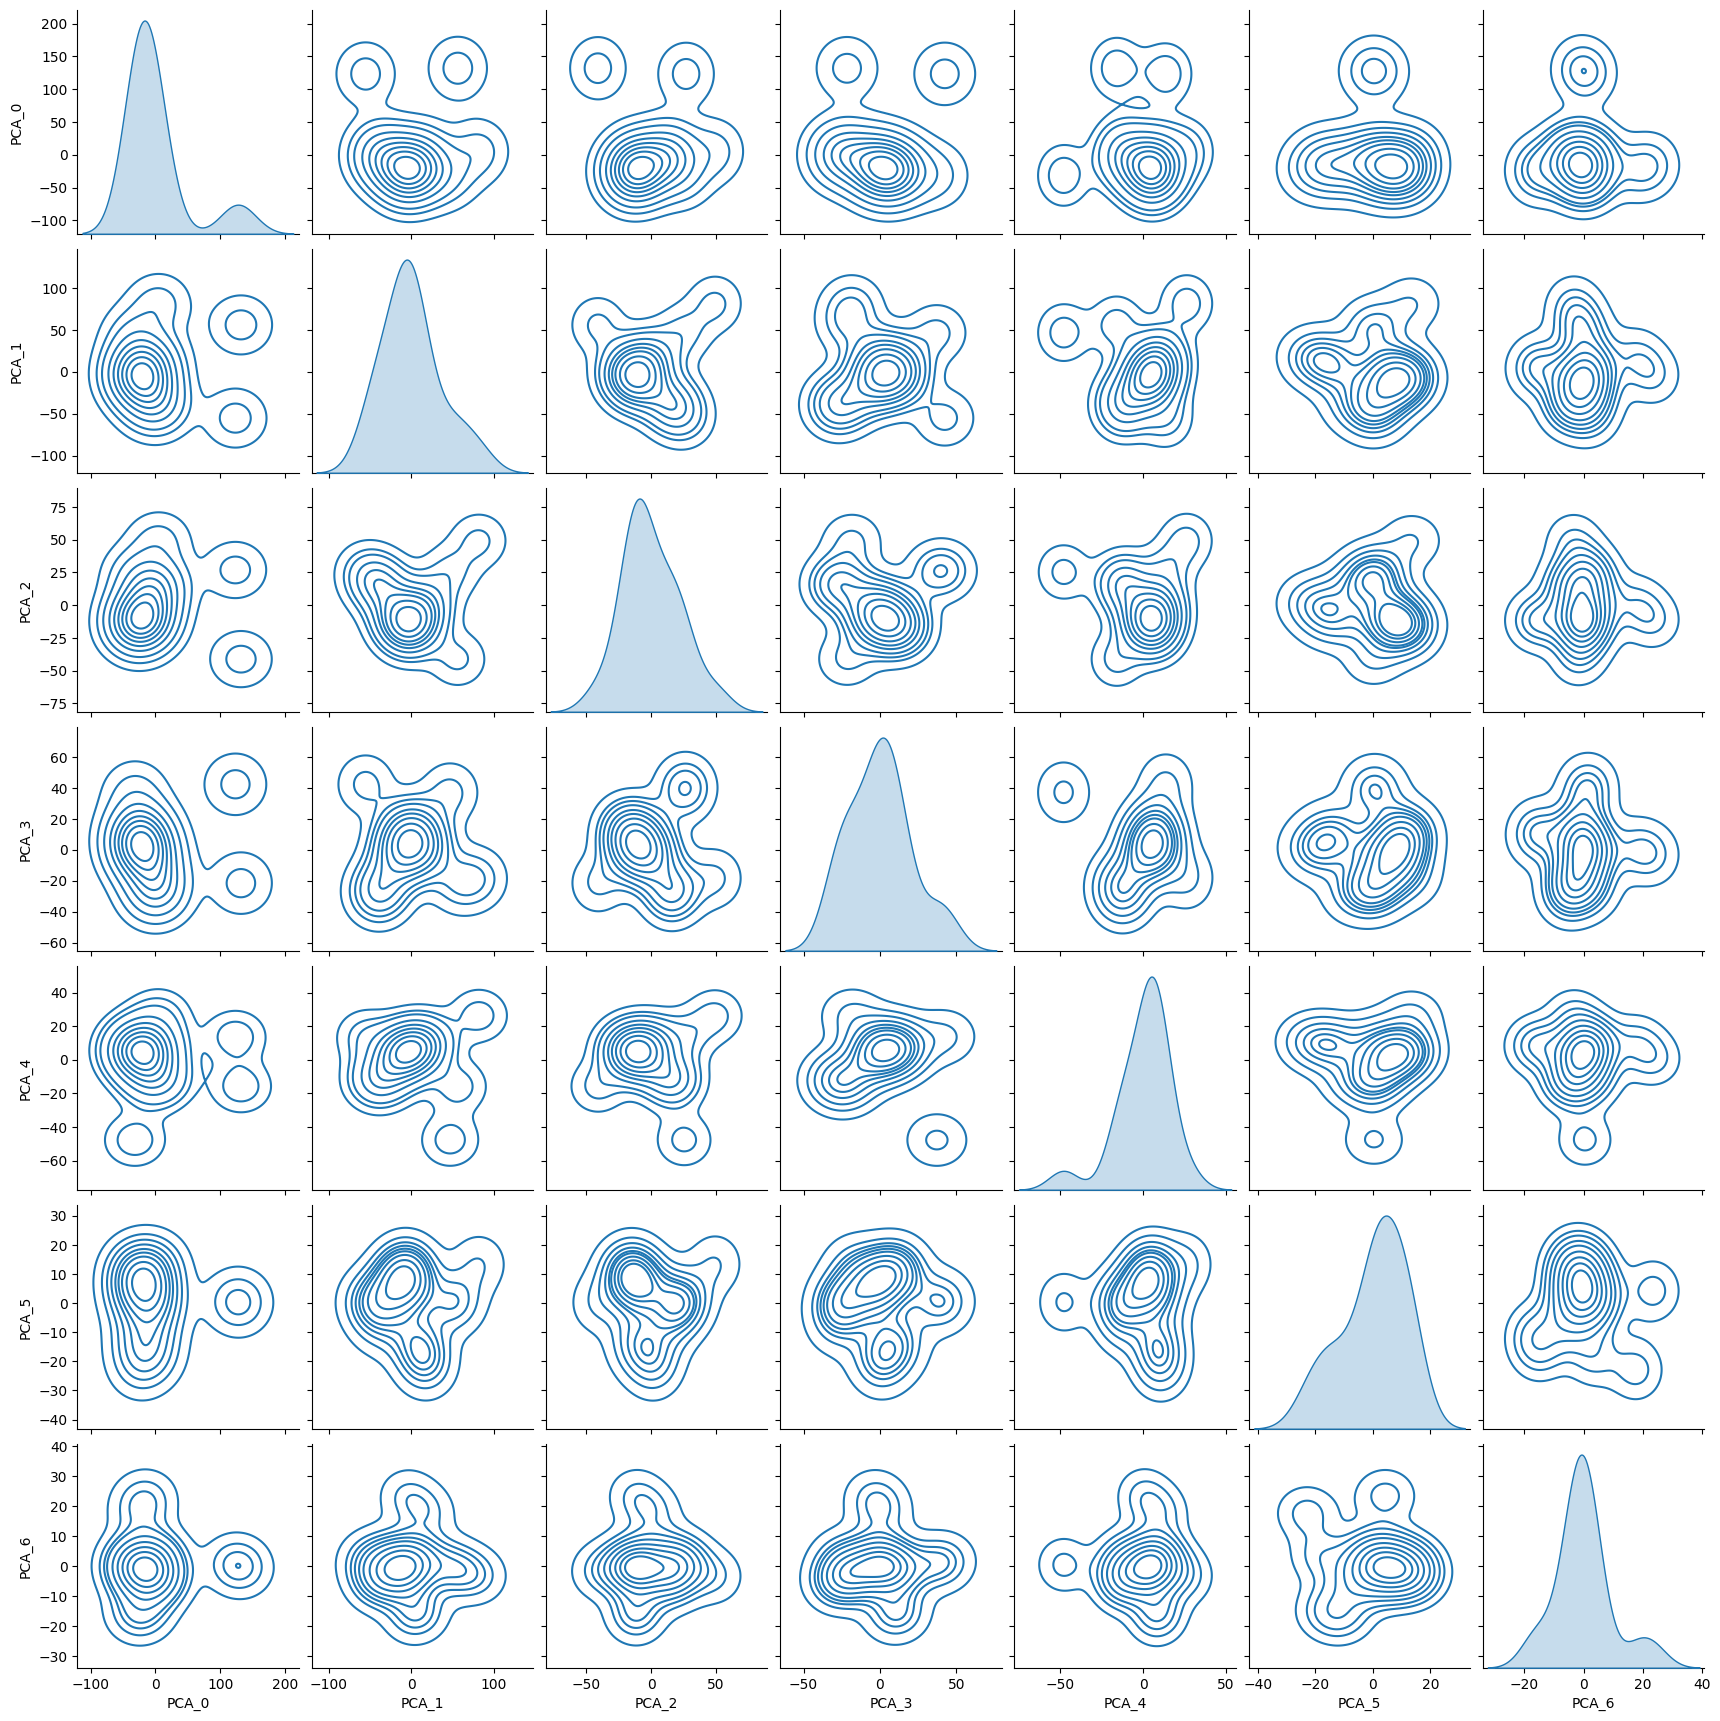

In [25]:
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(val_arr)

pca = PCA(n_components=variance_perc)
pca_arr = pca.fit_transform(scaled_arr)

print('Component-Compress: ', pca_arr.shape)

fig = plt.figure(figsize=(5, 5))

sns.pairplot(pd.DataFrame(pca_arr, columns=['PCA_' + str(i) for i in range(pca_arr.shape[-1])]), kind='kde')
plt.show()

In [26]:
cluster_labels = _agglo_cluster(pca_arr)
print('Number of Clusters: ', len(np.unique(cluster_labels)))

nunmber of clusters generated:  8
Number of Clusters:  8


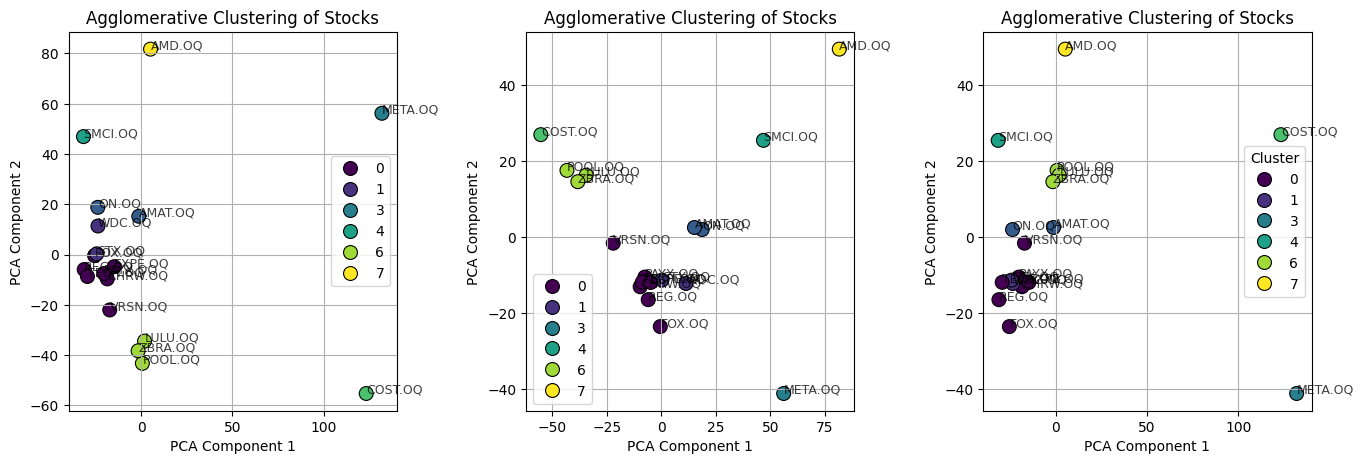

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 1], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[0])
sns.scatterplot(x=pca_arr[:, 1], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[1])
sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[2])

for i, stock in enumerate(stocks):
    axs[0].annotate(stock, (pca_arr[i, 0], pca_arr[i, 1]), fontsize=9, alpha=0.75)

for i, stock in enumerate(stocks):
    axs[1].annotate(stock, (pca_arr[i, 1], pca_arr[i, 2]), fontsize=9, alpha=0.75)

for i, stock in enumerate(stocks):
    axs[2].annotate(stock, (pca_arr[i, 0], pca_arr[i, 2]), fontsize=9, alpha=0.75)


axs[0].set_title("Agglomerative Clustering of Stocks")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

axs[1].set_title("Agglomerative Clustering of Stocks")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")

axs[2].set_title("Agglomerative Clustering of Stocks")
axs[2].set_xlabel("PCA Component 1")
axs[2].set_ylabel("PCA Component 2")

axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.legend(title="Cluster")
plt.tight_layout(pad=2)
plt.show()

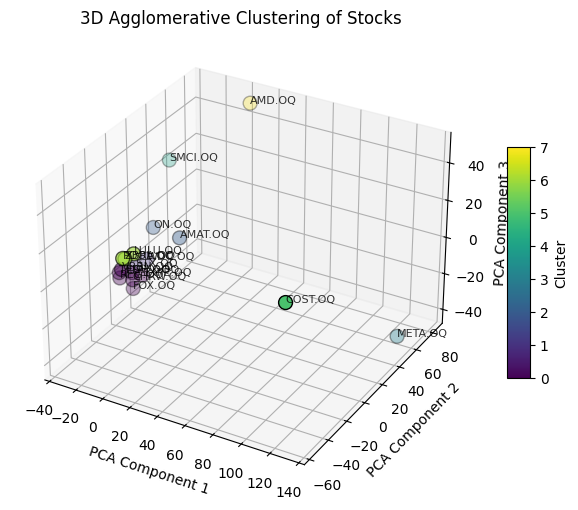

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_arr[:, 0], pca_arr[:, 1], pca_arr[:, 2], 
                c=cluster_labels, cmap="viridis", s=100, edgecolor="black")

for i, stock in enumerate(stocks):
    ax.text(pca_arr[i, 0], pca_arr[i, 1], pca_arr[i, 2], stock, fontsize=8, alpha=0.8)

ax.set_title("3D Agglomerative Clustering of Stocks")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster")

plt.show()

#### Co-Integration Selection + Volatility Weighted Portofolio Creation  

In [29]:
from utils.methods import SelectCointegratedPairs
from utils.methods import FilterHighCorrelationPairs  

print('Manual-Stock-Universe: ', ', '.join(stocks))

Manual-Stock-Universe:  POOL.OQ, CHRW.OQ, FOX.OQ, ON.OQ, SMCI.OQ, COST.OQ, LULU.OQ, PAYX.OQ, AMD.OQ, REG.OQ, WDC.OQ, ZBRA.OQ, AMAT.OQ, STX.OQ, VRSN.OQ, TECH.OQ, META.OQ, EXPE.OQ


In [30]:
pairs = SelectCointegratedPairs(symbols=stocks, cluster_labels=cluster_labels, history=df_uni)

print('Number of Pairs Found: ', len(pairs.keys()))

 ---- Clusters ---- 

{6: ['POOL.OQ', 'LULU.OQ', 'ZBRA.OQ'], 0: ['CHRW.OQ', 'FOX.OQ', 'PAYX.OQ', 'REG.OQ', 'VRSN.OQ', 'TECH.OQ', 'EXPE.OQ'], 2: ['ON.OQ', 'AMAT.OQ'], 4: ['SMCI.OQ'], 5: ['COST.OQ'], 7: ['AMD.OQ'], 1: ['WDC.OQ', 'STX.OQ'], 3: ['META.OQ']}

 ------------- 
Testing cointegration in cluster 6 with 3 symbols.
Testing cointegration in cluster 0 with 7 symbols.
Cointegrated pair found: REG.OQ_VRSN.OQ with p-value 0.03238098931051807 and Hurst -0.05
Cointegrated pair found: REG.OQ_EXPE.OQ with p-value 0.010640260694758036 and Hurst -0.08
Testing cointegration in cluster 2 with 2 symbols.
Testing cointegration in cluster 1 with 2 symbols.
Number of Pairs Found:  2


In [32]:
print(pairs.keys())
pairs['REG.OQ_VRSN.OQ']

dict_keys(['REG.OQ_VRSN.OQ', 'REG.OQ_EXPE.OQ'])


{'symbol_y': 'REG.OQ',
 'symbol_x': 'VRSN.OQ',
 'hedge_ratio': 0.07662129248853605,
 'spread_mean': 59.10077527112286,
 'spread_std': 1.108338614728679,
 'hurst': -0.05300405138797466,
 'spread_series': Date
 2021-01-04    27.905224
 2021-01-05    28.477703
 2021-01-06    30.313286
 2021-01-07    29.685742
 2021-01-08    29.978786
                 ...    
 2024-12-24    59.062342
 2024-12-26    59.076565
 2024-12-27    58.323087
 2024-12-30    57.694973
 2024-12-31    58.072457
 Name: TRDPRC_1, Length: 1005, dtype: Float64}

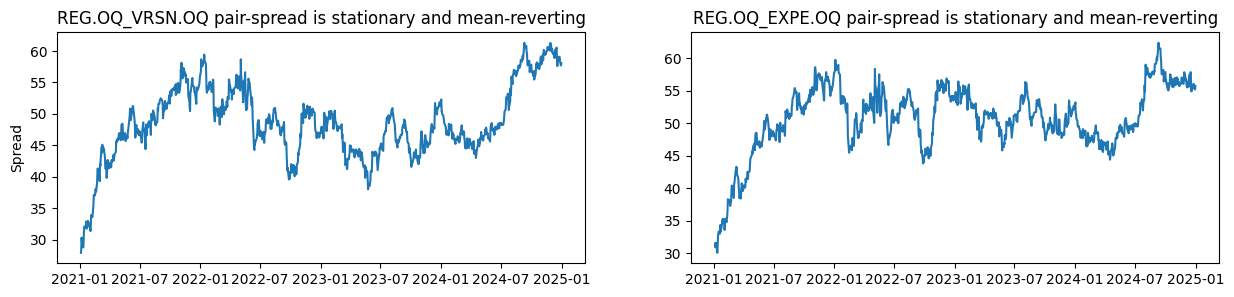

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

axs[0].plot(pairs[list(pairs.keys())[0]]['spread_series'])
axs[0].set_title(f'{list(pairs.keys())[0]} pair-spread is stationary and mean-reverting')
axs[0].set_ylabel('Spread')

axs[1].plot(pairs[list(pairs.keys())[-1]]['spread_series'])
axs[1].set_title(f'{list(pairs.keys())[-1]} pair-spread is stationary and mean-reverting')

plt.show()

In [34]:
# pairs = FilterHighCorrelationPairs(pairs)
# print(f"Number of pairs after correlation filtering: {len(pairs)}")

# if not pairs:
#     print("All pairs were filtered out due to high correlation.")

## Portfolio Construction

In [57]:
initial_amount = 500_000

##### Load S&P500 Benchmark

In [36]:
from utils.position import CalculateMarketVolatility, ManagePosition
import utils.position
importlib.reload(utils.position)
from utils.position import CalculateMarketVolatility, ManagePosition

In [37]:
# ft = time.time()
# df_benchmark = rd.get_history(universe=benchmark, fields=tmp_fields, interval="1D", start = start, end = end).dropna()
# lt = time.time()

# display(df_benchmark.head(5))

In [38]:
local_market_save_path = os.path.join(local_data_dir, 'market_S_P_500_4Y_1D.pkl') 

In [ ]:
# df_benchmark.to_pickle(local_market_save_path)

In [39]:
df_benchmark = pd.read_pickle(local_market_save_path)
df_benchmark.head(5)

SPY,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
Date,,,,,
2021-01-04,368.79,375.31,375.45,364.82,110210810
2021-01-05,371.33,368.1,372.5,368.05,66426229
2021-01-06,373.55,369.71,376.98,369.12,107997675
2021-01-07,379.1,376.1,379.9,375.91,68766812
2021-01-08,381.26,380.59,381.49,377.1,71677208


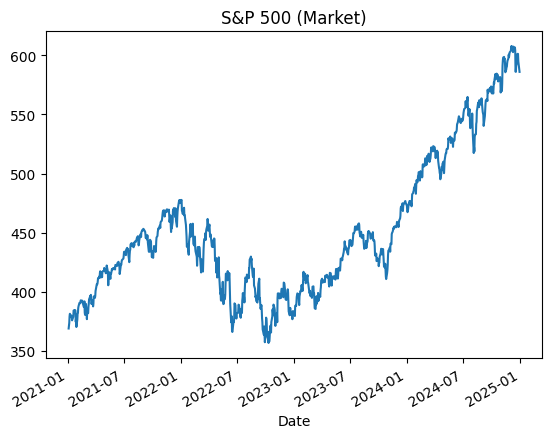

In [40]:
df_benchmark['TRDPRC_1'].plot()
plt.title("S&P 500 (Market)")
plt.show()

In [41]:
benchmark_vol = CalculateMarketVolatility(df_benchmark)
print('SPY-index Volatiliy (Market): ', benchmark_vol)

SPY-index Volatiliy (Market):  0.008429316271207946


#### Benchmark (daily-stats-arbs)

In [90]:
import utils.benchmark
importlib.reload(utils.benchmark)
from utils.benchmark import BenchmarkPortfolio

In [100]:
import utils.portfolio
importlib.reload(utils.portfolio)
from utils.portfolio import SignalPortfolio, SignalPortfolioConstrained

In [51]:
type(df_uni)

pandas.core.frame.DataFrame

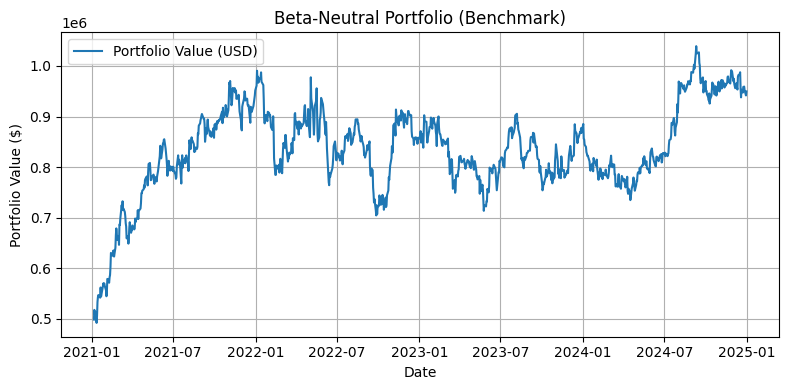

Sharpe Ratio: 0.7106
Max Drawdown: -28.86%
Portfolio Value: $949636.12
Portfolio-Beta:  0.7377472397065454


In [60]:
# Initialize and run the benchmark
benchmark = BenchmarkPortfolio(
    initial_amount = initial_amount,
    pairs=pairs,
    data_universe = df_uni,
    market_data=df_benchmark['TRDPRC_1'],
)

benchmark_results = benchmark.run()
benchmark.beta_neutral_check()

# Access results
cumulative_returns = benchmark_results['portfolio_value']
sharpe_ratio = benchmark_results['sharpe_ratio']
max_drawdown = benchmark_results['max_drawdown']

#### Z-Score Threshold - Long/Short - Mean Reverting

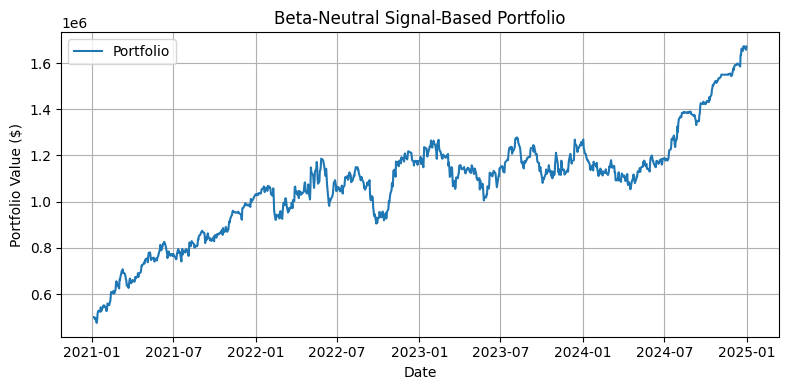

Sharpe Ratio: 1.2643
Max Drawdown: -23.70%
Portfolio Value: $1671531.12
Portfolio-Beta:  0.6558746999539223


In [74]:
# Initialize and run the benchmark
folio = SignalPortfolio(
    initial_amount = initial_amount,
    pairs=pairs,
    data_universe = df_uni,
    market_data=df_benchmark['TRDPRC_1'],
)


benchmark_results = folio.run()
folio.beta_neutral_check()

# Access results
cumulative_returns = benchmark_results['portfolio_value']
sharpe_ratio = benchmark_results['sharpe_ratio']
max_drawdown = benchmark_results['max_drawdown']

Pair-Name:  REG.OQ_VRSN.OQ


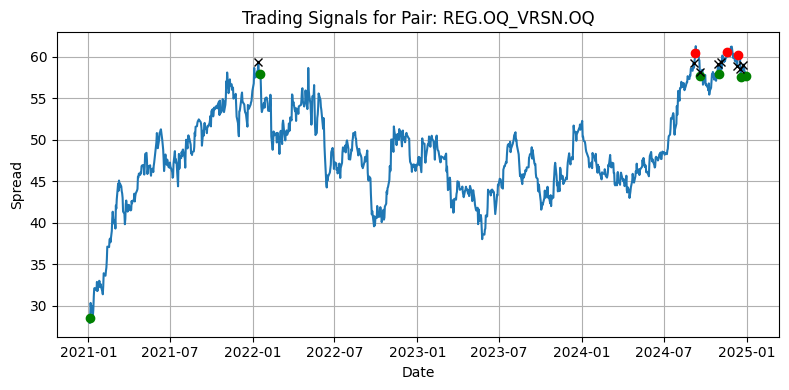

Pair-Name:  REG.OQ_EXPE.OQ


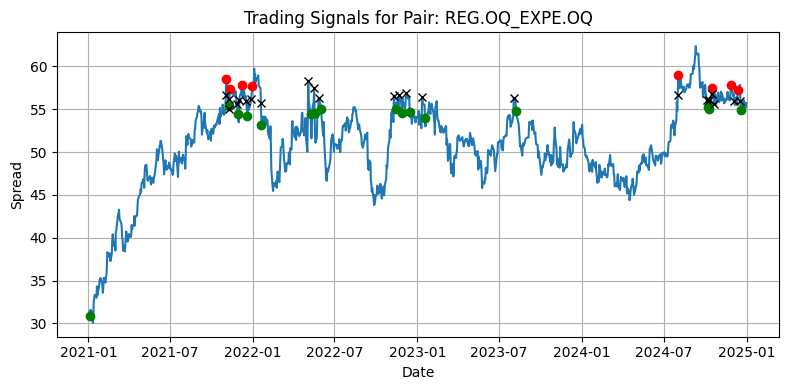

In [76]:
pair_name = list(pairs.keys())[0]
print('Pair-Name: ', pair_name)

folio.plot_pair_signals(pair_name)

pair_name = list(pairs.keys())[-1]
print('Pair-Name: ', pair_name)

folio.plot_pair_signals(pair_name)

Constrained

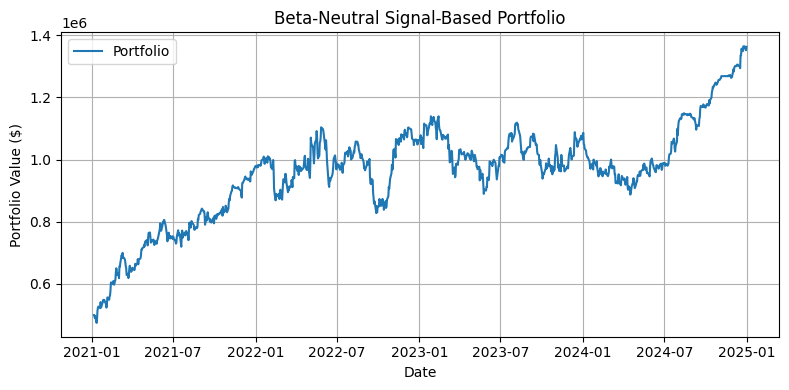

Sharpe Ratio: 1.0734
Max Drawdown: -25.00%
Portfolio Value: $1362982.51
Portfolio-Beta:  0.6540676998903616


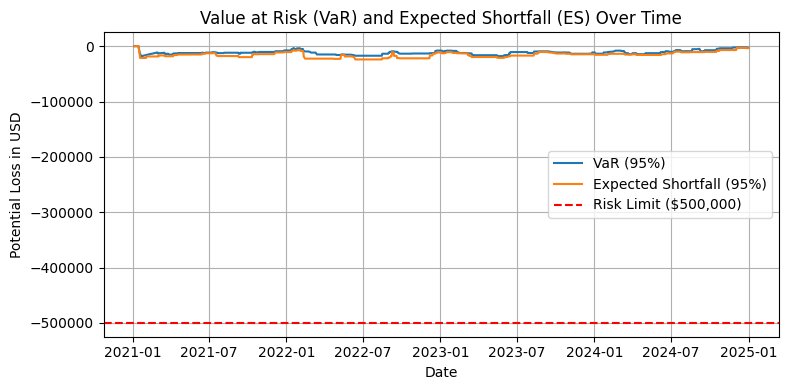

In [101]:
# Initialize and run the benchmark
folio = SignalPortfolioConstrained(
    initial_amount = initial_amount,
    pairs=pairs,
    data_universe = df_uni,
    market_data=df_benchmark['TRDPRC_1'],
)


benchmark_results = folio.run()
folio.beta_neutral_check()
folio.compute_var_es()
folio.plot_var_es_curve()

# Access results
cumulative_returns = benchmark_results['portfolio_value']
sharpe_ratio = benchmark_results['sharpe_ratio']
max_drawdown = benchmark_results['max_drawdown']

In [ ]:
# Liquidate positions not in new pairs
ManagePosition.LiquidatePositionsNotInPairs(pairs)

current_position = ManagePosition.create_position(pairs)

print('Current_Positioning ...')
pprint(current_position)

#### Maybe I need to chuck out a portfolio dataframe with dynamic sizing and weighting first - Maybe need to do it differently
Keep everything -> portfolio creation, export and portfolio backtesting LOCAL 

#### Modularised-Backtest (Working ... )

In [73]:
import utils 
import utils.backtest
importlib.reload(utils.backtest)
from utils.backtest import Backtest, simple_sma_strategy

In [ ]:
test_stock = stocks[0]
print('test_stock: ', test_stock)

test_stock:  POOL.OQ


POOL.OQ,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
Date,,,,,
2020-01-02,213.81,212.24,213.88,210.34,58656
2020-01-03,215.04,212.65,215.67,212.04,71042
2020-01-06,215.08,214.81,215.34,212.18,57866
2020-01-07,213.02,213.43,214.51,212.96,111786
2020-01-08,214.1,213.53,215.27,213.38,105380


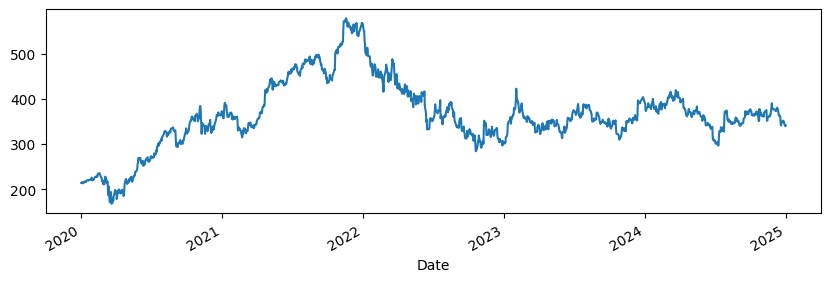

retrieval-time:  0.06206964254379273 mins


In [75]:
ft = time.time()
df_test_data = rd.get_history(universe=test_stock, fields=tmp_fields, interval="1D", start = hist_start_time, end = hist_end_time).dropna()
lt = time.time()

display(df_test_data.head(5))

plt.figure(figsize=(10, 3))

df_test_data['TRDPRC_1'].plot()
plt.show()

print('retrieval-time: ', (lt - ft) / 60, 'mins')


{'Total Return': '2.75%', 'Sharpe Ratio': '0.14', 'Max Drawdown': '-39.00%'}


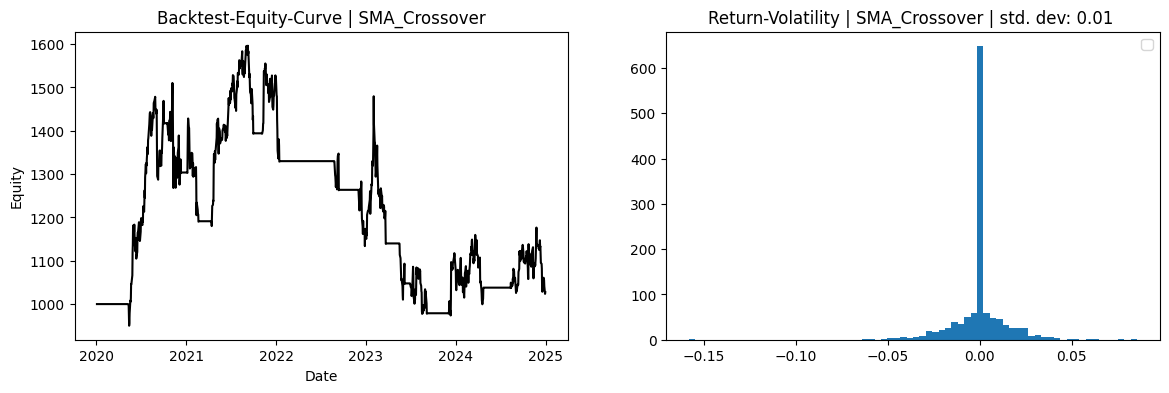

In [76]:
# Run backtest
backtest = Backtest(df_test_data, simple_sma_strategy, name='SMA_Crossover')
backtest.run()

# Print performance
print(backtest.performance())

# Plot equity curve
backtest.plot()

My first goal should be to complete the basic pipeline before tuning the actual algorithm. This includes an end-to-end implementation, from stock selection to sending hedged portfolios to the QRT FTP servers for the daily report.

### Data Presence Matrix OR Stock Presence Matrix (in Universe)

In [ ]:
sd.close_session()